# Understanding Browser Fingerprinting

Browser fingerprinting is a way of recognizing various attributes of a browser using the specific feature information like the type of font used or even a trivial thing like the type of emoji. It has its own pros and cons: If the goal is to protect uniqueness of a individual then it works fine in the case when an individual needs to be recognized to eliminate foul play but if the goal is mere advertisements then it can affect the privacy of a individual in a negative aspect. There have been various projects related to this genre which have worked to find which features are most important to recognize a specific website. Some of them which I went through are Panopticlick, AmIUnique.org, slido and Erik Flood and Joel Karlsson. Browser fingerprinting. 2012.



In [1]:
from dask.distributed import Client,progress
Client()


Client Scheduler: tcp://127.0.0.1:5480 Dashboard: http://127.0.0.1:8787,Cluster Workers: 4 Cores: 4 Memory: 8.50 GB


In [2]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar


In [3]:
import tldextract

#DATA_DIR = 'sample_10percent_value_1000_only.parquet'

def extract_domain(url):
    """Use tldextract to return the base domain from a url"""
    try:
        extracted = tldextract.extract(url)
        return '{}.{}'.format(extracted.domain, extracted.suffix)
    except Exception as e:
        return 'ERROR'

# Feature Evaluation

Based on my learning's I decided to further dive in features : " location, script-url, symbol and value1000'. On the basis of initial analysis I could understand that we can extract additional features from the script-url attribute with respect to symbol and value attribute. As various rows of location contained same urls but different symbol values which could uncover various important elements like font used through canvas fingerprinting , audio fingerprinting , Plugins used , screen size, useragent etc 
Based on features like font and in_iframe with respect to the scripts we would decide if a script would be blocked by adblock. 


In [15]:
#df = dd.read_parquet('sample_10percent_value_1000_only.parquet', engine='pyarrow',columns=['argument_0', 'func_name','in_iframe', 'location', 'script_url', 'symbol', 'time_stamp', 'value_1000'])

Trying to use only one part to analyse

In [4]:
df = dd.read_parquet('sample_10percent_value_1000_only.parquet\part.10.parquet', engine='pyarrow',columns=['argument_0', 'func_name','in_iframe', 'location', 'operation','script_url', 'symbol', 'time_stamp', 'value_1000'])

In [64]:
#df.head()
df.head()


,argument_0,func_name,in_iframe,location,operation,script_url,symbol,time_stamp,value_1000
0,None,__nr_require<.loader<,False,https://www.jumia.ma/soin-du-visage/,get,https://www.jumia.ma/soin-du-visage/,window.navigator.userAgent,2017-12-16 13:26:28.589,Mozilla/5.0 (X11; Linux x86_64; rv:52.0) Gecko...
1,None,__nr_require<[1]<,False,https://www.jumia.ma/soin-du-visage/,get,https://www.jumia.ma/soin-du-visage/,window.localStorage,2017-12-16 13:26:28.594,{}
2,__nr_flags,__nr_require<[1]<,False,https://www.jumia.ma/soin-du-visage/,call,https://www.jumia.ma/soin-du-visage/,window.Storage.getItem,2017-12-16 13:26:28.595,
3,None,__nr_require<[14]<,False,https://www.jumia.ma/soin-du-visage/,get,https://www.jumia.ma/soin-du-visage/,window.navigator.userAgent,2017-12-16 13:26:28.598,Mozilla/5.0 (X11; Linux x86_64; rv:52.0) Gecko...
4,None,n,False,https://www.jumia.ma/soin-du-visage/,get,https://www.jumia.ma/scripts/common_desktop.99...,window.localStorage,2017-12-16 13:26:29.267,{}


In [5]:
import pandas as pd
import numpy as np
import matplotlib 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso


C:\anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


I used the string processing functions from the repository:

In [6]:
from urllib.parse import urlparse

EMPTY_STRING = 'EMPTY_STRING'


def get_netloc(x):
    p = urlparse(x)
    val = p.netloc
    if len(val) == 0:
        val = EMPTY_STRING
    return val


def get_path(x):
    p = urlparse(x)
    val = p.path
    if len(val) == 0:
        val = EMPTY_STRING
    return val


def get_end_of_path(x):
    splits = x.split('/')
    val = ''
    if len(splits) > 0:
        val = splits[-1]
    else:
        val = x
    if len(val) == 0:
        val = EMPTY_STRING
    return val


def get_clean_script(x):
    p = urlparse(x)
    return f'{p.netloc}{p.path}'


In order to extract the features I segregated the location and script_domain as well as the symbols into subparts. This way I could get the locations and scripts with various features aggregated together.

In [27]:
df['script_netloc'] = df.script_url.apply(get_netloc, meta=('O'))
df['script_path'] = df.script_url.apply(get_path, meta=('O'))
df['script_path_end'] = df.script_path.apply(get_end_of_path, meta=('O'))
#df['agg'] = df.script_netloc + '||' + df.script_path_end + '||' + df.func_name
df['location_domain'] = df.location.apply(extract_domain, meta=('x', 'str'))

df['location_base_url'] = df.location.apply(get_netloc, meta=('x', 'str'))
df['script_domain'] = df.script_url.apply(extract_domain, meta=('x', 'str'))




In [7]:
df['symbol_parts'] = df.symbol.str.split('.')
df['symbol_0'] = df.symbol_parts.str.get(0)
df['symbol_1'] = df.symbol_parts.str.get(1)
df['symbol_2'] = df.symbol_parts.str.get(2)
df.head()

,argument_0,func_name,in_iframe,location,operation,script_url,symbol,time_stamp,value_1000,symbol_parts,symbol_0,symbol_1,symbol_2
0,None,__nr_require<.loader<,False,https://www.jumia.ma/soin-du-visage/,get,https://www.jumia.ma/soin-du-visage/,window.navigator.userAgent,2017-12-16 13:26:28.589,Mozilla/5.0 (X11; Linux x86_64; rv:52.0) Gecko...,"[window, navigator, userAgent]",window,navigator,userAgent
1,None,__nr_require<[1]<,False,https://www.jumia.ma/soin-du-visage/,get,https://www.jumia.ma/soin-du-visage/,window.localStorage,2017-12-16 13:26:28.594,{},"[window, localStorage]",window,localStorage,NaN
2,__nr_flags,__nr_require<[1]<,False,https://www.jumia.ma/soin-du-visage/,call,https://www.jumia.ma/soin-du-visage/,window.Storage.getItem,2017-12-16 13:26:28.595,,"[window, Storage, getItem]",window,Storage,getItem
3,None,__nr_require<[14]<,False,https://www.jumia.ma/soin-du-visage/,get,https://www.jumia.ma/soin-du-visage/,window.navigator.userAgent,2017-12-16 13:26:28.598,Mozilla/5.0 (X11; Linux x86_64; rv:52.0) Gecko...,"[window, navigator, userAgent]",window,navigator,userAgent
4,None,n,False,https://www.jumia.ma/soin-du-visage/,get,https://www.jumia.ma/scripts/common_desktop.99...,window.localStorage,2017-12-16 13:26:29.267,{},"[window, localStorage]",window,localStorage,NaN


Using a specific location or script_url, I tried to find out various features that can be analysed from the symbol column like plugin, userAgent, language, plugins etc. Some initial analysis I observed:

- Symbols are classified in 4 types : Window, HTMLcanvasElement,RTCPeerconnection,CanvasRenderingContext2D which can be further digged in order to find relationships between various attributes.
- Fingerprint2.js script has valid font value from which we can imply that the scripts which have valid font and plugin values have high probability of being a fingerprinting script.
- This dataset doesnot contain useragents from different mediums so we cannot analyze which medium is more vulnerable and why
- If we would have timestamps with different formats that can too affect the browser identification.
- When in_iframe is true we can imply that there is a possibility of a fingerprinting script.
- Some values have "Cwm fjordbank glyphs vext quiz" which is mentioned in various paper to be associated with canvas fingerprinting. This is said to be used to uniquely identify a browser almost accurately. If a mobile phone is considered , emojis are also considered as a significant trait to know about a browser as every mobile has unique way of representing its emojis. 

In [11]:
#win_df = df[df.]
#win_urls = win_df.location.unique().persist()
#progress(win_urls, notebook=False)
#len(win_df)


Further, using the string operations mentioned in issue_36 we can find significant factors that could tell us how a browser is recognized
- location : http://ca.puma.com/en_CA/kids	
- window.navigator.language : en-US
- window.navigator.plugins[Shockwave Flash].name: Shockwave Flash 28.0 r0
- window.Storage.length : 0
- window.screen.pixelDepth :24
- window.screen.colorDepth :24
- window.navigator.platform :Linux x86_64
- window.navigator.doNotTrack :unspecified
- window.navigator.userAgent: Mozilla/5.0 (X11; Linux x86_64; rv:52.0) Gecko/20100101 Firefox/52.0
- Time_stamp	: 12/16/2017  3:46:19 AM

## Audio fingerprint aspect

OfflineAudioContex/AudioContext
- createOscillator
- createDynamicsCompressor
- destination
- startRendering
- oncomplete


## Canvas fingerprinting aspect
CanvasRenderingContext2D
- font
- getImagedata
- Fill/fillstyle
- globalcompositionoperation

HTMLCanvasElement
- Height,width,style,draggable


The initial process is to consider a certain script_url and its corresponding features like pulgin, font, language , screen size. We consider individual symbol calls that includes window, HTMLCanvasElement, RTCPeerConnection, CanvasRenderingContext2D. 

In [11]:
win_df = df[df.symbol_0 == 'window']
win_urls = win_df.script_url.unique().persist()
progress(win_urls, notebook=False)
print(' # Total window occurences',len(win_df))
print(' # unique window occurences',len(win_urls))

[########################################] | 100% Completed |  0.0s # Total window occurences 35417
 # unique window occurences 1498


In [16]:
html_df = df[df.symbol_0 == 'HTMLCanvasElement']
html_urls =html_df.script_url.unique().persist()
progress(html_urls, notebook=False)

print(' # Total HTMLCanvasElement occurences',len(html_df ))
print(' # unique HTMLCanvasElement occurences',len(html_urls))

[########################################] | 100% Completed |  0.1s # Total HTMLCanvasElement occurences 856
 # unique HTMLCanvasElement occurences 57


In [15]:
RTC_df = df[df.symbol_0 == 'RTCPeerConnection']
RTC_urls = RTC_df.location.unique().persist()
progress(RTC_urls, notebook=False)
len(RTC_urls )
print(' # Total RTCPeerConnection occurences',len(RTC_df ))
print(' # unique RTCPeerConnection occurences',len(RTC_urls))

[########################################] | 100% Completed |  0.1s # Total RTCPeerConnection occurences 101
 # unique RTCPeerConnection occurences 11


In [17]:
canvas_df = df[df.symbol_0 == 'CanvasRenderingContext2D']
canvas_urls = canvas_df.location.unique().persist()
progress(RTC_urls, notebook=False)
print(' # Total CanvasRenderingContext2D occurences',len(canvas_df ))
print(' # unique CanvasRenderingContext2D occurences',len(canvas_urls ))

[########################################] | 100% Completed |  0.1s # Total CanvasRenderingContext2D occurences 1948
 # unique CanvasRenderingContext2D occurences 31


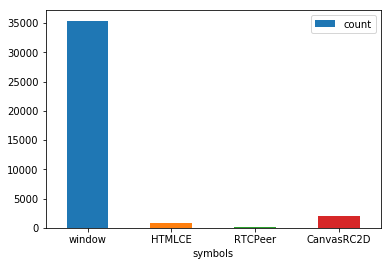

In [20]:
dfplot = pd.DataFrame({'symbols':['window','HTMLCE','RTCPeer','CanvasRC2D'], 'count':[35417,856,101,1948]})
ax = dfplot.plot.bar(x='symbols', y='count', rot=0)

In [21]:
feature_plugin_df = df[df.symbol_2 == 'plugins[Shockwave Flash]']
fp_urls = feature_plugin_df.location.unique().persist()
progress(fp_urls, notebook=False)


[########################################] | 100% Completed |  1.9s

In [22]:
fp_urls = fp_urls.compute()
fp_urls[0:5]


0             https://theporndude.com/989/babesmachine
1    https://ad.doubleclick.net/ddm/adi/N5620.15339...
2    http://www.lazada.com.ph/shop-air-conditioners...
3               http://animefreak.tv/watch/pupa-online
4    http://www.eventim.de/disneys-musical-tarzan-i...
Name: location, dtype: object

In [23]:
len(fp_urls)

192

In [24]:
featur_font_df = df[df.symbol_1 == 'font']
ff_urls = featur_font_df.location.unique().persist()
progress(ff_urls, notebook=False)
print(' # unique font features',len(ff_urls))

[########################################] | 100% Completed |  2.3s # unique font features 22


In [25]:
ffnu_urls = featur_font_df.location.persist()
progress(ffnu_urls, notebook=False)
ffnu_urls = ffnu_urls.compute()
print(' # total font features',len(ffnu_urls))

[########################################] | 100% Completed |  2.2s # total font features 131


In [26]:
ff_urls = ff_urls.compute()
ff_urls[0:5]

0    http://www.eventim.de/disneys-musical-tarzan-i...
1    https://www.hesport.com/matches.html?season=14113
2                  http://www.oregonlive.com/trending/
3    https://w.soundcloud.com/player/?url=https%3A/...
4                https://filmakinesi.org/kategori/spor
Name: location, dtype: object

## Plugins and Fonts
According to some papers, the plugins with list of fonts are  very significant in order to identify a browser. For example, Iphone is considered to be least affected by browser fingerprinting as it has no flash setting. Hence Desktop machines are more vulnerable to this than mobile browsers. Hence we find number of locations which share fonnt and plugin information and that are 16 out of total 37234 records in this one parquete file. In many cases the flash plugin is a feature of google analytics script but when a script_url has both flash and font features and fonts are asked for multiple times it can be concluded as a fingerprinting script.

In [27]:
togethrfp_urls = set(fp_urls) & \
    set(ffnu_urls) 
print('# of location using plugins and font features', len(togethrfp_urls))

# of location using plugins and font features 16


# Entropy
Entropy is used for categorical features in order to find number of occurence of certain value in an attribute. This is also used in decision tree to find right questions to ask. Here Entropy of combined plugins and fonts is to be considered.

# Further Analysis
I have used Excel for most of my analysis due to the size of file and memory limitation on my side. That being said , I have mostly focused on location , symbol and value feature which could sufficiently identify a browser on the basis of its font type, user-agent, Date format , platform ,Canvas and audio fingerprint. I plan to use entropy to find the feature combination that is best to identify a browser. We still have the question of which urls could be blocked by adblocks? I decided to consider in_iframe , location , operation and script_url attributes to scratch the surface of the problem. The heuristic here is to check whether the feature in_iframe is true and script_url of a certain location has a '.js' file with similar '.js' file blocked in the past. Can we build a model to predict if a script would be blocked by adblock or not? 
We could consider features with highest entropy to uniquely identify a browser and train the model based on the past data.